### Resources:

- http://norvig.com/ngrams/
- https://github.com/Saleh-I/keras_tutorial/blob/master/multi_input_multi_output.ipynb
- https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/

In [89]:
#!pip install textaugment
#!pip install nlpaug

In [1]:
import re
import sys

import pickle
import scipy.io as sio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from tqdm import tqdm
import os, re, csv, math, codecs

from gensim.models import KeyedVectors, Word2Vec, FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import tensorflow as tf

from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras import optimizers
from keras import regularizers
from keras import backend as K
from keras.models import Sequential

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils.vis_utils import plot_model
from keras.models import Model, Input
from keras.layers import Dense, Flatten, Dropout, Embedding, BatchNormalization, Bidirectional,LSTM, Concatenate, TimeDistributed
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, SimpleRNN, Lambda, SpatialDropout1D

#from keras.layers.merge import concatenate

from Text_Features import *

from attention import Attention
from keras_self_attention import SeqSelfAttention


In [2]:
from textaugment import Wordnet, EDA

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Dataset OCEAN Loaded 7711 1941
85


c:\program files\python36\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

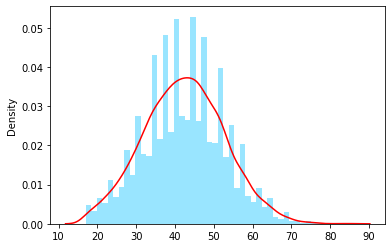

In [7]:
Train_df = pd.concat([pd.read_csv("Dataset/Train.csv"), pd.read_csv("Dataset/Validation.csv")])
#Train_df = pd.read_csv("Dataset/Train.csv")
#Val_df = pd.read_csv("Dataset/Validation.csv")

Test_df = pd.read_csv("Dataset/Test.csv")

'AGRE	CONS	EXTR	NEUR	OPEN	INTER'
y_train = np.round(Train_df['INTER'].to_numpy(), 4)
#y_val = np.round(Test_df['NEUR'].to_numpy(), 4)
y_test = np.round(Test_df['INTER'].to_numpy(), 4)

#y_train = Train_df.iloc[:, 1:7].to_numpy()
#y_test = Test_df.iloc[:, 1:7].to_numpy()

print('Dataset OCEAN Loaded', Train_df.shape[0], Test_df.shape[0])

#Train_Emo_df = pd.concat([pd.read_csv("Emotions/Emotions_Train.csv"), pd.read_csv("Emotions/Emotions_Validation.csv")])
#Test_Emo_df = pd.read_csv("Emotions/Emotions_Test.csv")
#print('Dataset OCEAN Emotions Loaded', Train_Emo_df.shape[0], Test_Emo_df.shape[0])

seq_len = np.array(Train_df['Trans_len'].tolist())
max_seq_len = np.max(seq_len)
print(max_seq_len)

sns.distplot(seq_len, hist=True, kde=True, kde_kws={"color": "r"}, color='deepskyblue', label='doc len')

#sns.distplot(y_train, hist=True, kde=True, kde_kws={"color": "r"}, color='deepskyblue', label='doc len')
#sns.distplot(y_test, hist=True, kde=True, kde_kws={"color": "g"}, color='orange', label='doc len')

In [239]:
def Data_augmentation(df):
    column_names = ['Transcript', 'AGRE','CONS','EXTR','NEUR','OPEN','INTER']

    df_new = pd.DataFrame(columns = column_names)
                  
    wn = Wordnet(v=True ,n=False, p=0.95)
    t = EDA()
    
    for index, row in df.iterrows():
        df_new.loc[len(df_new.index)] = [row['Transcript'], row['AGRE'], row['CONS'], row['EXTR'], row['NEUR'], row['OPEN'], row['INTER']]
        df_new.loc[len(df_new.index)] = [wn.augment(row['Transcript']), row['AGRE'], row['CONS'], row['EXTR'], row['NEUR'], row['OPEN'], row['INTER']]
#        df_new.loc[len(df_new.index)] = [t.random_insertion(row['Transcript']), row['AGRE'], row['CONS'], row['EXTR'], row['NEUR'], row['OPEN'], row['INTER']]
#        df_new.loc[len(df_new.index)] = [t.random_deletion(row['Transcript'], p=0.2), row['AGRE'], row['CONS'], row['EXTR'], row['NEUR'], row['OPEN'], row['INTER']]
#        df_new.loc[len(df_new.index)] = [t.random_swap(row['Transcript']), row['AGRE'], row['CONS'], row['EXTR'], row['NEUR'], row['OPEN'], row['INTER']]

    return df_new

Train_df = Data_augmentation(Train_df)

In [240]:
y_train = Train_df['NEUR'].to_numpy()
seq_len = np.array([len(i.split()) for i in Train_df['Transcript'].tolist()])
max_seq_len = np.max(seq_len)

In [258]:
Train_df#.iloc[:, 1:7]

,Transcript,AGRE,CONS,EXTR,NEUR,OPEN,INTER,Trans_len
0,he is cutting it and then turn around and see ...,0.626374,0.601942,0.523364,0.552083,0.488889,0.504673,49
1,responsibility to house the organ had been giv...,0.472527,0.582524,0.345794,0.375000,0.366667,0.457944,37
2,actually got quite a few sets of black pens th...,0.406593,0.485437,0.252336,0.291667,0.511111,0.373832,45
3,ate a lot would like a lot of foods remember h...,0.505495,0.398058,0.457944,0.489583,0.377778,0.457944,35
4,now will ask you guys to leave a question in t...,0.406593,0.621359,0.607477,0.489583,0.622222,0.570093,35
...,...,...,...,...,...,...,...,...
1936,really qualified to the guy who last week was ...,0.494505,0.689320,0.570093,0.614583,0.577778,0.626168,65
1937,wearing scarfs on the second date okay so no h...,0.549451,0.669903,0.542056,0.541667,0.666667,0.579439,27
1938,how do you manage to do things with someone ho...,0.560440,0.572816,0.551402,0.593750,0.644444,0.504673,38
1939,sell no sophie loveland will you be posting a ...,0.461538,0.572816,0.514019,0.552083,0.733333,0.551402,31


In [259]:
y_train

array([0.5521, 0.375 , 0.2917, ..., 0.5938, 0.5521, 0.6354])

In [260]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])
 
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [7]:
path = 'C:/Users/user/Desktop/PretrainedModels/'

#load embeddings
print('loading word embeddings...')
embeddings_index = {}
#f = codecs.open(path+'wiki.simple.vec', encoding='utf-8')
#f = codecs.open(path+'wiki-news-300d-1M.vec', encoding='utf-8')
f = codecs.open(path+'glove.6B.300d.txt', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

614it [00:00, 6084.76it/s]

loading word embeddings...


400000it [01:04, 6163.32it/s]

found 400000 word vectors


In [261]:
# create tokenizer
tokenizer = create_tokenizer(Train_df['Transcript'].tolist())
word_index = tokenizer.word_index

# calculate max document length
length = max_length(Train_df['Transcript'].tolist())
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
# encode data
train_X = encode_text(tokenizer, Train_df['Transcript'].tolist(), length)
#val_X = encode_text(tokenizer, Val_df['Transcript'].tolist(), length)
test_X = encode_text(tokenizer, Test_df['Transcript'].tolist(), length)
print(length, train_X.shape, test_X.shape)

Max document length: 85
Vocabulary size: 12376
85 (7711, 85) (1941, 85)


In [262]:
batch_size = 256 
num_epochs = 32
Voc_size = vocab_size
#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4
MAX_NB_WORDS = 100000

maxlen_word = 25

In [63]:
print("dictionary size: ", len(word_index)+1)

#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
#embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))
embedding_matrix = np.random.random((len(word_index) + 1, embed_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
#print("sample words not found: ", words_not_found)

dictionary size:  12376
preparing embedding matrix...


NameError: name 'embeddings_index' is not defined

In [264]:
path = 'C:/Users/user/Desktop/PretrainedModels/'
model = KeyedVectors.load_word2vec_format(path+'GoogleNews-vectors-negative300.bin', binary=True)

#path = 'Features/OCEAN_'
#model = Word2Vec.load(path+'Doc2Vec'+'.bin')
#model = Word2Vec.load(path+'Pre_W2Vec.bin')

#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
#embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))

np.random.seed(3)#42
embedding_matrix = np.random.random((len(word_index) + 1, embed_dim))

for word, i in word_index.items():
    if word in model.vocab:
    #if word in list(model.wv.vocab):    
        embedding_matrix[i] = model[word]
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
#print("sample words not found: ", words_not_found)

preparing embedding matrix...
number of null word embeddings: 0


In [265]:
W2V = embedding_matrix.copy()
W2V.shape

(12376, 300)

In [14]:
embedding_matrix = W2V.copy()

In [42]:
train_pos = POS(Train_df['Transcript'].tolist())
test_pos = POS(Test_df['Transcript'].tolist())

# create tokenizer
tokenizer = create_tokenizer(train_pos)
# calculate max document length
length = max_length(train_pos)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
# encode data
train_pos = encode_text(tokenizer, train_pos, length)
test_pos = encode_text(tokenizer, test_pos, length)
print(train_X.shape, test_X.shape)

Max document length: 85
Vocabulary size: 33
(7711, 85) (1941, 85)


In [26]:
train_Emo = Train_Emo_df[Train_Emo_df.columns[1:]].to_numpy()
test_Emo = Test_Emo_df[Test_Emo_df.columns[1:]].to_numpy()

### Deep Learning Features

In [266]:
def Performance(y_true, y_pred):
    return 1 - K.mean(K.abs(y_pred - y_true))

def plot_History(history):
    plt.plot(history.history['Performance'])
    plt.plot(history.history['val_Performance'])

    plt.title('model performance')
    plt.ylabel('Performance')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

In [267]:
class CNN_Text_Reg(Model):
    def __init__(self, max_seq_len, Voc_size):
        super(CNN_Text_Reg, self).__init__()
        self.max_seq_len = max_seq_len
        self.Voc_size = Voc_size
        
        self.embedding = Embedding(self.Voc_size, 300, input_length=self.max_seq_len, trainable=False, weights=[embedding_matrix])
        self.SDropout = SpatialDropout1D(0.05)
        
        self.conv1d = Conv1D(512, 64, activation='relu')
        #self.gmp = GlobalMaxPooling1D()
        self.gap = GlobalAveragePooling1D()
        self.dropout = Dropout(0.2)
    
        self.fc = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        #self.dropout = Dropout(0.2)
        self.fc1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        #model.add(Dropout(0.2))
        self.fc2 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.regressor = Dense(1, activation='linear')

    def call(self, inputs):
        if len(inputs.get_shape()) != 2:
            raise ValueError('The rank of inputs of TextAttBiRNN must be 2, but now is %d' % len(inputs.get_shape()))
        if inputs.get_shape()[1] != max_seq_len:
            raise ValueError('The maxlen of inputs of TextAttBiRNN must be %d, but now is %d' % (max_seq_len, inputs.get_shape()[1]))
       
        embedding = self.embedding(inputs)
        #embedding = self.SDropout(embedding)

        x = self.conv1d(embedding)
        x = self.gap(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.fc1(x)
        x = self.fc2(x)
        output = self.regressor(x)
        return output

model = CNN_Text_Reg(max_seq_len, Voc_size)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(loss='mae', optimizer=adam, metrics=[Performance])

In [288]:
class Text_Att_Bi_LSTM(Model):
    def __init__(self, max_seq_len, Voc_size):
        super(Text_Att_Bi_LSTM, self).__init__()

        self.max_seq_len = max_seq_len
        self.Voc_size = Voc_size
        
        self.embedding = Embedding(self.Voc_size, 300, input_length=self.max_seq_len, trainable=False, weights=[embedding_matrix])
        self.SDropout = SpatialDropout1D(0.05)
        
        self.bi_lstm = Bidirectional(LSTM(512, return_sequences=True))
        #self.attention = Attention(max_seq_len)
        
        self.attention = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL, kernel_regularizer=regularizers.l2(1e-4),
                       bias_regularizer=regularizers.l1(1e-4), attention_regularizer_weight=1e-4, name='Attention')
        
        #self.attention = SeqSelfAttention(attention_activation='sigmoid')
        #self.flat = Flatten()
        self.conv1d = Conv1D(512, 64, activation='relu')
        self.gap = GlobalMaxPooling1D()
        #self.gap = GlobalAveragePooling1D()


        self.fc = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer='he_uniform')
        
        self.fc1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer='he_uniform')
        self.dropout = Dropout(0.5)
        
        self.fc2 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer='he_uniform')
        
        self.fc3 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer='he_uniform')
        self.dropout2 = Dropout(0.2)
        
        self.fc4 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer='glorot_uniform')
        
        self.regressor = Dense(1, activation='linear')

    def call(self, inputs):
        if len(inputs.get_shape()) != 2:
            raise ValueError('The rank of inputs of TextAttBiRNN must be 2, but now is %d' % len(inputs.get_shape()))
        if inputs.get_shape()[1] != max_seq_len:
            raise ValueError('The maxlen of inputs of TextAttBiRNN must be %d, but now is %d' % (max_seq_len, inputs.get_shape()[1]))
       
        embedding = self.embedding(inputs)
#        embedding = self.SDropout(embedding)
        x = self.bi_lstm(embedding)
        x = self.attention(x)
        
#        x = self.conv1d(x)
#        x = self.gap(x)
        
        #x = self.flat(x)
        x0 = self.fc(x)
        x = self.fc1(x0)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.fc3(x)
        #x = self.dropout2(x)
        #x = self.fc4(x)
        
        #x = Concatenate()([x0, x])#
        
        output = self.regressor(x)
        return output

model = Text_Att_Bi_LSTM(max_seq_len, Voc_size)

#opt = optimizers.Adam(lr=0.0006, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
#opt = optimizers.SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_absolute_error', optimizer=opt, metrics=[Performance])

In [27]:
def hello():
    print ("Hello World")
class C():
    @staticmethod
    def AGRE():
        print ("Hello World AGRE")
    def CONS():
        print ("Hello World CONS")
    @staticmethod
    def build():
        hello()
        C.AGRE()
        C.CONS()
            
C().build()

Hello World
Hello World AGRE
Hello World CONS


In [12]:
class OCEANI():
    def AGRE(word_input, max_seq_len, name='name'):
        embedding = Embedding(Voc_size, 300, input_length=max_seq_len, trainable=False, weights=[embedding_matrix])(word_input)
        bi_lstm = Bidirectional(LSTM(128, return_sequences=True))(embedding)
        attention = Attention(max_seq_len)(bi_lstm)
        fc = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(attention)
        regressor = Dense(1, activation='linear', name=name)(fc)#, kernel_initializer='glorot_uniform'
        return regressor
    
    @staticmethod
    def CONS(word_input, max_seq_len, name='name'):
        embedding = Embedding(Voc_size, 300, input_length=max_seq_len, trainable=False, weights=[embedding_matrix])(word_input)
        bi_lstm = Bidirectional(LSTM(128, return_sequences=True))(embedding)
        attention = Attention(max_seq_len)(bi_lstm)
        fc = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(attention)
        regressor = Dense(1, activation='linear', name=name)(fc)#, kernel_initializer='glorot_uniform'
        return regressor
    
    @staticmethod
    def EXTR(word_input, max_seq_len, name='name'):
        embedding = Embedding(Voc_size, 300, input_length=max_seq_len, trainable=False, weights=[embedding_matrix])(word_input)
        bi_lstm = Bidirectional(LSTM(128, return_sequences=True))(embedding)
        attention = Attention(max_seq_len)(bi_lstm)
        fc = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(attention)
        regressor = Dense(1, activation='linear', name=name)(fc)#, kernel_initializer='glorot_uniform'
        return regressor
    
    @staticmethod
    def NEUR(word_input, max_seq_len, name='name'):
        embedding = Embedding(Voc_size, 300, input_length=max_seq_len, trainable=False, weights=[embedding_matrix])(word_input)
        bi_lstm = Bidirectional(LSTM(128, return_sequences=True))(embedding)
        attention = Attention(max_seq_len)(bi_lstm)
        fc = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(attention)
        regressor = Dense(1, activation='linear', name=name)(fc)#, kernel_initializer='glorot_uniform'
        return regressor
    
    @staticmethod
    def OPEN(word_input, max_seq_len, name='name'):
        embedding = Embedding(Voc_size, 300, input_length=max_seq_len, trainable=False, weights=[embedding_matrix])(word_input)
        bi_lstm = Bidirectional(LSTM(128, return_sequences=True))(embedding)
        attention = Attention(max_seq_len)(bi_lstm)
        fc = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(attention)
        regressor = Dense(1, activation='linear', name=name)(fc)#, kernel_initializer='glorot_uniform'
        return regressor
    
    @staticmethod
    def INTER(word_input, max_seq_len, name='name'):
        embedding = Embedding(Voc_size, 300, input_length=max_seq_len, trainable=False, weights=[embedding_matrix])(word_input)
        bi_lstm = Bidirectional(LSTM(128, return_sequences=True))(embedding)
        attention = Attention(max_seq_len)(bi_lstm)
        fc = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(attention)
        regressor = Dense(1, activation='linear', name=name)(fc)#, kernel_initializer='glorot_uniform'
        return regressor
    
    @staticmethod
    def build(Voc_size, max_seq_len):
        word_input = Input(shape=(max_seq_len,), dtype='float64')  

        AGRE_Branch = OCEANI.AGRE(word_input, max_seq_len, 'AGRE')
        CONS_Branch = OCEANI.CONS(word_input, max_seq_len, 'CONS')
        EXTR_Branch = OCEANI.EXTR(word_input, max_seq_len, 'EXTR')
        NEUR_Branch = OCEANI.NEUR(word_input, max_seq_len, 'NEUR')
        OPEN_Branch = OCEANI.OPEN(word_input, max_seq_len, 'OPEN')
        INTER_Branch = OCEANI.INTER(word_input, max_seq_len, 'INTER')

        model = Model(inputs=[word_input], 
                      outputs=[AGRE_Branch, CONS_Branch, EXTR_Branch, NEUR_Branch, OPEN_Branch, INTER_Branch], name="OCEANI_Net")
        return model

model = OCEANI.build(Voc_size, max_seq_len)

losses = {'AGRE':'mae', 'CONS':'mae', 'EXTR':'mae', 'NEUR':'mae', 'OPEN':'mae', 'INTER':'mae'}
lossWeights = {'AGRE':1.0, 'CONS':1.0, 'EXTR':1.0, 'NEUR':1.0, 'OPEN':1.0, 'INTER':1.0}
Metrics = {'AGRE':Performance, 'CONS':Performance, 'EXTR':Performance, 'NEUR':Performance, 'OPEN':Performance, 'INTER':Performance}

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(optimizer=adam, loss=losses, loss_weights=lossWeights, metrics=Metrics)
#model.compile(optimizer=adam, loss='mae', loss_weights=1.0, metrics=[Performance])

model.summary()


Model: "OCEANI_Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 85)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 85, 300)      3712800     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 85, 300)      3712800     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 85, 300)      3712800     input_1[0][0]                    
_________________________________________________________________________________________

In [51]:
class Multi_Modal_Text_Reg(Model):
    def __init__(self, max_seq_len, Voc_size):
        super(Multi_Modal_Text_Reg, self).__init__()
        
        self.max_seq_len = max_seq_len
        self.Voc_size = Voc_size
        
        self.embedding1 = Embedding(self.Voc_size, 300, input_length=self.max_seq_len, trainable=True, weights=[embedding_matrix])
        #self.SDropout1 = SpatialDropout1D(0.05)
        self.bi_lstm1 = Bidirectional(LSTM(512, return_sequences=True))
        self.attention1 = Attention(max_seq_len)
        self.out1 = Dense(128, activation='relu')
        
        self.embedding2 = Embedding(33, 300, trainable=False)
        self.bi_lstm2 = Bidirectional(LSTM(512, return_sequences=True))
        self.attention2 = Attention(max_seq_len)
        self.conv2 = Conv1D(filters=512, kernel_size=64, activation='relu')
        self.gap2 = GlobalAveragePooling1D()
        self.out2 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))

        self.fc3 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.out3 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        
        self.dense = Dense(300, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.regressor = Dense(1, activation='linear')


    def call(self, inputs):
       
        embedding1 = self.embedding1(inputs[0])
        #embedding1 = self.SDropout1(embedding1)
        out1 = self.bi_lstm1(embedding1)
        out1 = self.attention1(out1)
        out1 = self.out1(out1)

        embedding2 = self.embedding2(inputs[1])
        out2 = self.conv2(embedding2)
        out2 = self.gap2(out2)
        out2 = self.out2(out2)
        
        out3 = self.fc3(inputs[2])
        out3 = self.out3(out3)
        
        merged = Concatenate()([out1, out2, out3])#
        output = self.dense(merged)
        output = self.regressor(output)
        return output

model = Multi_Modal_Text_Reg(max_seq_len, Voc_size)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(loss='mae', optimizer=adam, metrics=[Performance])

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [61]:
# define the model
def define_model():
	# Text
	inputs1 = Input(shape=(85,))
	embedding1 = Embedding(12376, 300, trainable=False)(inputs1)
	bi_lstm = Bidirectional(LSTM(512, return_sequences=True))(embedding1)
	out1 = Attention(85)(bi_lstm)
	out1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(out1)
	out1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(out1)
	out1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(out1)
    
    # POS
	inputs2 = Input(shape=(85,))
	embedding2 = Embedding(33, 300, trainable=False)(inputs2)
	conv2 = Conv1D(filters=512, kernel_size=64, activation='relu')(embedding2)
	out2 = GlobalMaxPooling1D()(conv2)
	out2 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(out2)
	out2 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(out2)
	out2 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(out2)

    # Emotions
	inputs3 = Input(shape=(5,))
	out3 = Dense(512, activation='relu')(inputs3)
	out3 = Dense(256, activation='relu')(out3)
	out3 = Dense(128, activation='relu')(out3)
    
	# merge
#	merged1 = concatenate([out1, out2])
#	merged2 = concatenate([out1, out3])
#	merged3 = concatenate([out2, out3])

	# interpretation
#	dense1 = Dense(100, activation='relu')(merged1)
#	dense2 = Dense(100, activation='relu')(merged2)
#	dense3 = Dense(100, activation='relu')(merged3)

	merged = Concatenate()([out1, out2, out3])
	dense = Dense(300, activation='relu')(merged)

	outputs = Dense(1, activation='linear')(dense)
    
	model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
	return model

# define the model
def define_model2():
    # Text
    inputs1 = Input(shape=(85,))
    out1 = Embedding(12376, 300, trainable=False, weights=[embedding_matrix])(inputs1)
    out1 = SpatialDropout1D(0.05)(out1)
    #out1 = Conv1D(filters=512, kernel_size=64, activation='relu')(out1)
    #out1 = GlobalAveragePooling1D()(out1)

    out1 = Bidirectional(LSTM(512, return_sequences=True))(out1)
    out1 = Attention(85)(out1)
    
        
    out1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4), kernel_initializer='glorot_uniform')(out1)
    out1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(out1)
    out1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4), kernel_initializer='glorot_uniform')(out1)
    out1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4), kernel_initializer='glorot_uniform')(out1)
    out1 = Dropout(0.2)(out1)

    regressor = Dense(1, activation='linear')(out1)
    
    model = Model(inputs=[inputs1], outputs=regressor)
    return model

model = define_model()

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(loss='mae', optimizer=adam, metrics=[Performance])

In [27]:
#checkpoint = ModelCheckpoint('Checkpoints/model-{epoch:03d}-OCEANI-{val_INTER_Performance:03f}.h5', verbose=1, monitor='val_INTER_Performance',save_best_only=True, mode='max')  
#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='min')

#history = model.fit(train_X, y_train, batch_size=32, epochs=16, verbose=1, validation_split=0.25)#, validation_data=(test_X, y_test)
#history = model.fit(train_X, y_train, batch_size=32, epochs=16, verbose=1, callbacks=[checkpoint], validation_split=0.25)#, validation_data=(test_X, y_test)

Epoch 1/32
43/43 [==============================] - 26s 491ms/step - loss: 1.0450 - Performance: 0.2671 - val_loss: 0.4591 - val_Performance: 0.8212

Epoch 00001: val_Performance improved from -inf to 0.82116, saving model to Checkpoints\model-001-0.578162-0.821161.h5
Epoch 2/32
43/43 [==============================] - 19s 449ms/step - loss: 0.4231 - Performance: 0.8542 - val_loss: 0.3868 - val_Performance: 0.8781

Epoch 00002: val_Performance improved from 0.82116 to 0.87811, saving model to Checkpoints\model-002-0.858416-0.878106.h5
Epoch 3/32
43/43 [==============================] - 20s 462ms/step - loss: 0.4009 - Performance: 0.8601 - val_loss: 0.3922 - val_Performance: 0.8570

Epoch 00003: val_Performance did not improve from 0.87811
Epoch 4/32
43/43 [==============================] - 20s 460ms/step - loss: 0.3739 - Performance: 0.8723 - val_loss: 0.3878 - val_Performance: 0.8478

Epoch 00004: val_Performance did not improve from 0.87811
Epoch 5/32
43/43 [=========================

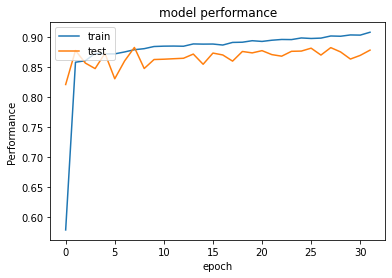

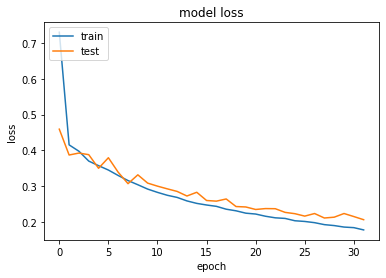

In [289]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
checkpoint = ModelCheckpoint('Checkpoints/model-{epoch:03d}-{Performance:03f}-{val_Performance:03f}.h5', verbose=1, monitor='val_Performance',save_best_only=True, mode='max')  
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='min')

history = model.fit(train_X, y_train, batch_size=128, epochs=32, verbose=1, shuffle=True, callbacks=[checkpoint, reduce_lr_loss, earlyStopping], validation_split=0.3)#, validation_data=(test_X, y_test)
#history = model.fit([train_X, train_Emo], y_train, batch_size=128, epochs=16, verbose=True, shuffle=True, validation_data=([test_X, test_Emo], y_test))#, validation_data=(test_X, y_test)

#history = model.fit([train_X, train_pos, train_Emo], y_train, batch_size=32, epochs=16, verbose=1, callbacks=[checkpoint, reduce_lr_loss], validation_split=0.25)
#history = model.fit([train_X, train_pos, train_Emo], y_train, batch_size=32, epochs=32, verbose=1)#, validation_data=(test_X, y_test)

plot_History(history)

In [290]:
#model.load_weights('Checkpoints\model-001-0.872150-0.901879.h5')
#score = model.evaluate(x=[test_X, test_pos, test_Emo], y=y_test, verbose=1)

score = model.evaluate(test_X, y_test, verbose=1)

61/61 [==============================] - 27s 445ms/step - loss: 0.2085 - Performance: 0.8754


In [292]:
#model = load_model('Best-Model/model-008-0.954247-0.889771.h5', custom_objects={"Performance": Performance})
#model.load_weights('Best-Model/model-001-0.866808-0.890341.h5')
model.load_weights('Checkpoints\model-008-0.879316-0.883119.h5')#Han
score = model.evaluate(test_X, y_test, verbose=1)

61/61 [==============================] - 27s 432ms/step - loss: 0.3114 - Performance: 0.8780
